In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tarfile
import glob
from matplotlib.colors import LogNorm
import pathlib
import pickle

In [39]:
# Inputs ETH
run_type = 'brca'

if run_type == 'brca':
   
    sample_target = 'TCGA-AO-A0JM-01A-21R-A056-07'
    samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                      'TCGA-AO-A0JM-01A-21R-A056-07',
                      'TCGA-BH-A18V-01A-11R-A12D-07',
                      'TCGA-A2-A0D2-01A-21R-A034-07',
                      'TCGA-A2-A0SX-01A-12R-A084-07']
    basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
elif run_type == 'ov':
    sample_target = 'TCGA-25-1319-01A-01R-1565-13'
    samples = ['TCGA-25-1319-01A-01R-1565-13',
                      'TCGA-25-1313-01A-01R-1565-13',
                      'TCGA-61-2008-01A-02R-1568-13',
                      'TCGA-24-1431-01A-01R-1566-13',
                      'TCGA-24-2298-01A-01R-1569-13']
    basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'

filtering_id = 'filters_19May_order_5ge_wAnnot_GPstar'
filter_dir = os.path.join(basedir, 'filtering_samples', filtering_id)


# PLOT
plot_dir = os.path.join(filter_dir, 'plots')
base_plot = sample_target
pathlib.Path(plot_dir).mkdir(parents=True, exist_ok=True)

# OHSU
files_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/current/kmer_files'

In [40]:
# ETH Names
eth_all = glob.glob(os.path.join(filter_dir, 'G*'))
eth_all = [i for i in eth_all if len(os.path.basename(i)) == 45] #Shorten path has len 45


In [41]:
# OHSU Names
ohsu_all = glob.glob(os.path.join(files_OHSU, 'J*'))

In [42]:
# Get file pairs
file_pair = {}
for idx_eth, eth in enumerate(eth_all):
    eth_pattern = os.path.basename(eth).replace('G_', '').replace('.gz', '') 
    for idx_ohsu, ohsu in enumerate(ohsu_all):
        if eth_pattern in ohsu:
            file_pair[eth] = ohsu

            

In [43]:
print(len(file_pair))

175


In [44]:
all_ohsu = set(ohsu_all) #TODO PLOT THE OHSU motifs matching ETH
print(len(all_ohsu))

1800


In [45]:
found_ohsu = set(file_pair.values())
found_eth = set(file_pair.keys()) 

In [46]:
all_eth = set(eth_all)
print(len(all_eth))

325


In [47]:
len(all_eth - found_eth)

150

In [48]:
len(all_ohsu - found_ohsu)

1625

In [49]:
print(len(all_ohsu & all_eth))

0


# Collect Data to plot

In [50]:
### Compute the intersection sizes on the fly for the sample
restrict = ''
df = {'sample' : [], 
      'filter_' : [], 
      #'filter_foreground' : [], 
      #'filter_background' : [], 
      'size_ohsu' : [], 
      'size_eth' : [], 
      'size_intersection' : [], 
      'size_ohsu\eth' : [], 
      'size_eth\ohsu' : []}
for eth, ohsu in file_pair.items(): # ETH
    if (not restrict) or restrict in eth: #Restrict to category of interest
        try:
            df_ohsu = pd.read_csv(ohsu, sep="\t")
            df_ohsu = df_ohsu.reset_index().rename({'index': 'kmer', 'kmer': 'coord'}, axis = 1) 
            df_eth = pd.read_csv(eth, sep="\t", usecols = ['kmer'])

            df_eth = set(df_eth['kmer'])
            df_ohsu = set(df_ohsu['kmer'])
            
            name = os.path.basename(eth).replace('.tsv', '').replace('.gz', '').split('_')
            
            df['sample'].append(name[1])
            df['filter_'].append(name[2])
            df['size_ohsu'].append(len(df_ohsu))
            df['size_eth'].append(len(df_eth))
            df['size_ohsu\eth'].append(len(df_ohsu.difference(df_eth)))
            df['size_eth\ohsu'].append(len(df_eth.difference(df_ohsu)))
            df['size_intersection'].append(len(df_ohsu.intersection(df_eth)))
            #                 df['filter_foreground'].append(name[2])
#                 df['filter_background'].append(name[3])
        except:
            continue


In [51]:
df = pd.DataFrame(df)

In [52]:
save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

In [53]:
file_name = 'data_kmers_filtering_ohsu_eth.tsv.gz'

In [54]:
df.to_csv(os.path.join(save_folder, file_name), index=None, sep='\t')

# Plot Set size

In [19]:
## Separate filter values
df['filter_foreground_target']  = [i[0] for i in df['filter_'].values]
df['filter_foreground_reads'] =  [i[1] for i in df['filter_'].values]
df['filter_foreground_samples'] = [i[2] for i in df['filter_'].values]
df['filter_background_reads'] = [i[3] for i in df['filter_'].values]
df['filter_background_samples'] = [i[4] for i in df['filter_'].values]
df['cohort'] = [i[5] for i in df['filter_'].values]
df['motif'] = [i[6] for i in df['filter_'].values]

In [20]:
# Prepare Plot ticks
def prepare_backticks(a, b):
    return  [f'({i}, {j})' for i, j in zip(a.values, b.values)]
def prepare_frontticks(a, b, c):
    return  [f'({i}, {j}, {k})' for i, j, k in zip(a.values, b.values, c.values)]


In [21]:
# Sort Valus for plot
df = df.sort_values(['size_intersection', 
                     'filter_foreground_target',
                     'filter_foreground_reads', 
                     'filter_foreground_samples', 
                     'filter_background_reads', 
                     'filter_background_samples'
                    ])
df['index'] = np.arange(len(df))

back_ticks = prepare_backticks(df['filter_background_reads'], df['filter_background_samples'])
front_ticks = prepare_frontticks(df['filter_foreground_target'], df['filter_foreground_reads'], df['filter_foreground_samples'])
df['filter_background'] = back_ticks
df['filter_foreground'] = front_ticks

In [22]:
# Plot Helper
def plot_text(Y, T, position='top', color='black', font=None):
    font['color'] = color
    Y = np.array(Y)
    T = np.array(T)
    Y[np.where(Y > 0 )[0]]
    T[np.where(Y > 0 )[0]]
    change_val = [i for i in np.arange(len(Y) - 1) if Y[i] != Y[i - 1]]    
    weighted = [change_val[i] + (change_val[i+1] - change_val[i]) / 2 for i, x in enumerate(change_val[:-1])]
    X = [np.floor(change_val[i] + (change_val[i+1] - change_val[i]) / 2) for i, x in enumerate(change_val[:-1])]
    Y = Y[np.array(change_val[:-1])]
    T = T[np.array(change_val[:-1])]
    p_prev = 0 
    percent_diff = 20
    min_x = min(X)
    
    previous_plot = 0 
    for x, y, p in zip(X, Y, T):
        if position == 'bottom':
            delta = - (y/5.5)
        elif position == 'top': 
            delta = (y/12)
        if (p > p_prev + (p_prev/percent_diff)) or (p < p_prev - (p_prev/percent_diff)):
            previous_plot += 1
        if previous_plot == 2 or x == min_x: # delay the plotting
            if y != 0 : # Because log scale
                plt.text(x - 0.5 , y + delta , p, ha='left', **font)
                previous_plot = 0
                
        p_prev = p 

def plot_text_all(X, Y, T):
    for x, y, p in zip(X, Y, T):
        plt.text(x, y, p)
        #plt.text(x - 0.5 , y + (y/10), p)


/scratch/slurm-job.3987441/ipykernel_1487847/625256470.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.3987441/ipykernel_1487847/625256470.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
/scratch/slurm-job.3987441/ipykernel_1487847/625256470.py:26: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_ovelap.pdf


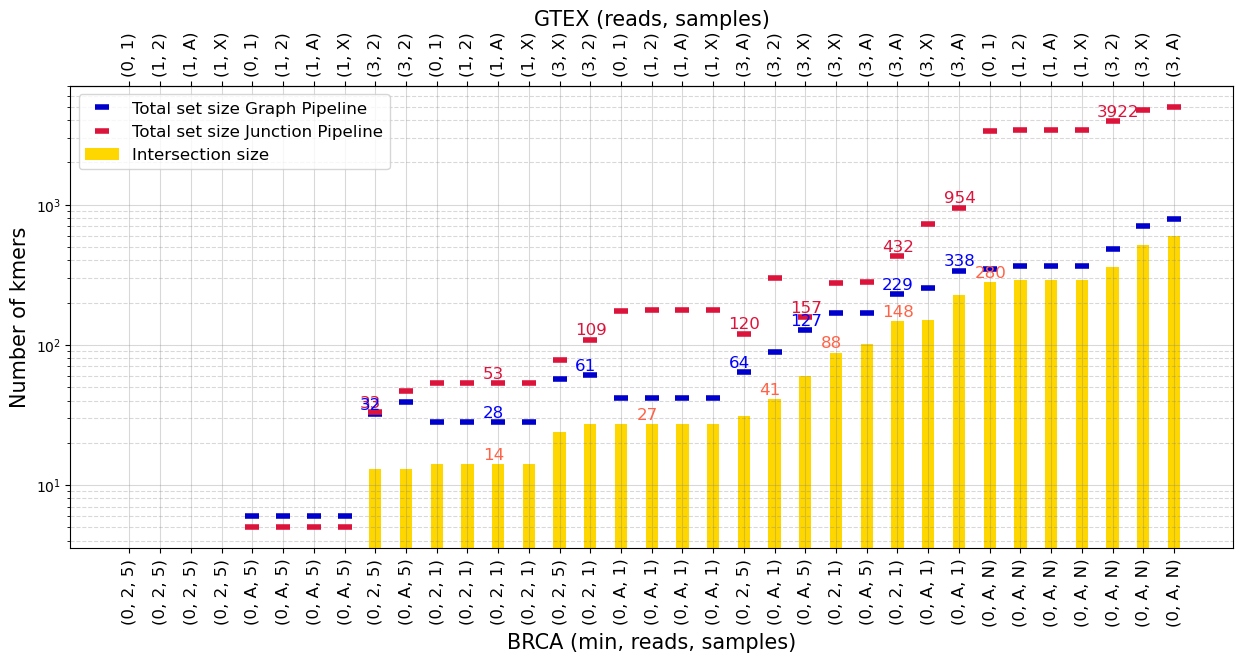

In [23]:
# Plot
text_font = {'size':'12', 'weight':'normal'}
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15

xaxis_label = 'GTEX (reads, samples)'
yaxis_label = f'{run_type.upper()} (min, reads, samples)'


colorgrid = 'grey'
alpha_grid = 0.3
marker_size = 10
mew = 4
color1 = 'gold'
color2 = 'crimson'
color4 = 'mediumblue'
colorgrid = 'grey'


fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 =  ax1.secondary_xaxis('top')   
#plt.figure(figsize=(15, 6), frameon=False, dpi=100)
plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
width = 0.4
plt.bar(df['index'], df['size_intersection'], width=width, 
        color=color1, label='Intersection size')
plt.plot(df['index'], df['size_eth'], alpha=1, color=color4,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Graph Pipeline')
plt.plot(df['index'], df['size_ohsu'], alpha=1, color=color2,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Junction Pipeline')

plot_text(df['size_ohsu'], df['size_ohsu'], 'top', color='crimson', font=text_font)
plot_text(df['size_eth'], df['size_eth'], 'top', color='blue', font=text_font)
plot_text(df['size_intersection'], df['size_intersection'], color='tomato', font=text_font)

plt.yscale('log')
max_scale = np.max([df['size_ohsu'].values, df['size_eth'].values])



ax1.set_xticks(np.arange(len(df['index'])), 
           labels = front_ticks,
           rotation = 90, 
           ha = 'center', 
           fontsize=ticks_fontsize)

ax2.set_xticks(np.arange(len(df['index'])), 
           labels = back_ticks,
           rotation = 90, 
           ha = 'center', 
           fontsize=ticks_fontsize)


plt.legend(fontsize=legend_fontsize)
plt.ylabel('Number of kmers', fontsize=axes_fontsize)
ax2.set_xlabel(xaxis_label, fontsize=axes_fontsize)
ax1.set_xlabel(yaxis_label, fontsize=axes_fontsize)



save = True
name = 'Barplot_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
plt.show()

In [24]:
save_path

'/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_ovelap.pdf'

In [25]:
name = 'Barplot_sorting'
sorting_path = os.path.join(plot_dir, f'{base_plot}_{name}.tsv.gz')
print(f'Saving order to {sorting_path}')
df.to_csv(sorting_path, sep = '\t', index = None)

Saving order to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_sorting.tsv.gz


# Plot Intersections

In [26]:
df.columns

Index(['sample', 'filter_', 'size_ohsu', 'size_eth', 'size_intersection',
       'size_ohsu\eth', 'size_eth\ohsu', 'filter_foreground_target',
       'filter_foreground_reads', 'filter_foreground_samples',
       'filter_background_reads', 'filter_background_samples', 'cohort',
       'motif', 'index', 'filter_background', 'filter_foreground'],
      dtype='object')

In [27]:
# Sort Valus for plot
df = df.sort_values(['size_eth', 
                     'filter_foreground_target',
                     'filter_foreground_reads', 
                     'filter_foreground_samples', 
                     'filter_background_reads', 
                     'filter_background_samples'
                    ], 
                   ascending=[False, False, False, False, False, False])
df['index'] = np.arange(len(df))

order_foreground = df['filter_foreground'].unique()
order_background = df['filter_background'].unique()


In [28]:
# Collect plot data
titles = ['Intersection size', 
'Total set size Graph Pipeline', 
'Total set size Junction Pipeline']
xaxis_label = 'GTEX (reads, samples)'
yaxis_label = f'{run_type.upper()} (min, reads, samples)'

df_plot = []
for f in ['size_intersection', 'size_eth', 'size_ohsu']: #, 'size_ohsu\eth', 'size_eth\ohsu']:
    # Extract the intersection
    df_inter = df.pivot(index = 'filter_foreground', columns = 'filter_background', values = f )
    # Enforce order
    df_inter = df_inter.loc[order_foreground, order_background]
    df_plot.append(df_inter)
    


In [29]:
xticks_font_size = 15
label_font_size = 15
tick_font_size = 12

/scratch/slurm-job.3987441/ipykernel_1487847/638118107.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(panelplot)
/scratch/slurm-job.3987441/ipykernel_1487847/638118107.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


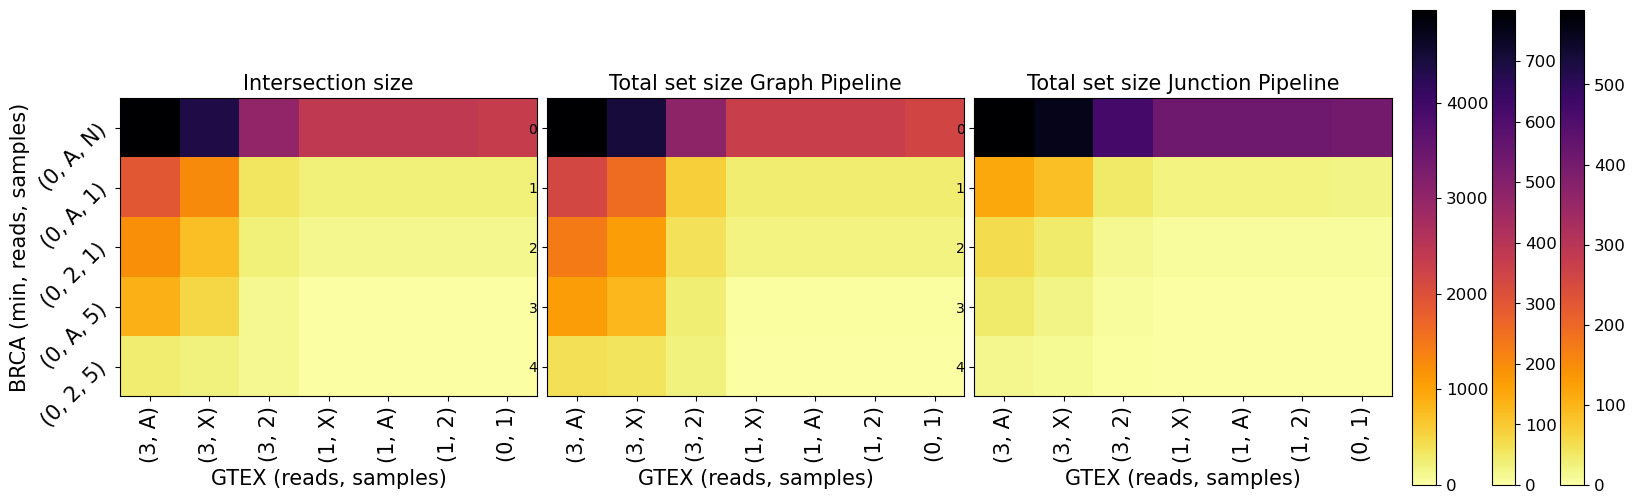

In [30]:
# Plot

nprow = 1
npcol = 3
fig = plt.figure(figsize=(15, 6), layout='constrained')
axes = [fig.add_subplot(nprow, npcol, i) for i in range(1,npcol+1)]

#vmin = max(1, np.min([df['size_eth'], df['size_ohsu']]))
#vmax = np.max([df['size_eth'], df['size_ohsu']]) #1e5
for pane_idx in np.arange(npcol):
    panelplot=axes[pane_idx].imshow(df_plot[pane_idx], origin='upper', 
                                    cmap='inferno_r') #norm=LogNorm(vmin=vmin, vmax=vmax))
    # x-axis 
    axes[pane_idx].set_title(titles[pane_idx], fontsize=label_font_size)
    axes[pane_idx].set_xlabel(xaxis_label, fontsize=label_font_size)
    axes[pane_idx].set_xticks(range(df_plot[pane_idx].shape[1]))
#    axes[pane_idx].set_xticklabels(prepare_backticks(df_plot[pane_idx].columns), rotation = 90 )
    axes[pane_idx].set_xticklabels(df_plot[pane_idx].columns, rotation = 90, fontsize=xticks_font_size)

    if pane_idx == 0 :
        # y-axis
        axes[pane_idx].set_ylabel(yaxis_label, fontsize=label_font_size)
        axes[pane_idx].set_yticks(range(df_plot[pane_idx].shape[0]))
#        axes[pane_idx].set_yticklabels(prepare_frontticks(df_plot[pane_idx].index), rotation = 45 )
        axes[pane_idx].set_yticklabels(df_plot[pane_idx].index, rotation = 45, fontsize=xticks_font_size)

    cbar = plt.colorbar(panelplot)
    cbar.ax.tick_params(labelsize=tick_font_size)

save = False
name = 'Matrix_ovelap_split'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
fig.show()


save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Matrix_ovelap.pdf


/scratch/slurm-job.3924589/ipykernel_3236203/2776359300.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


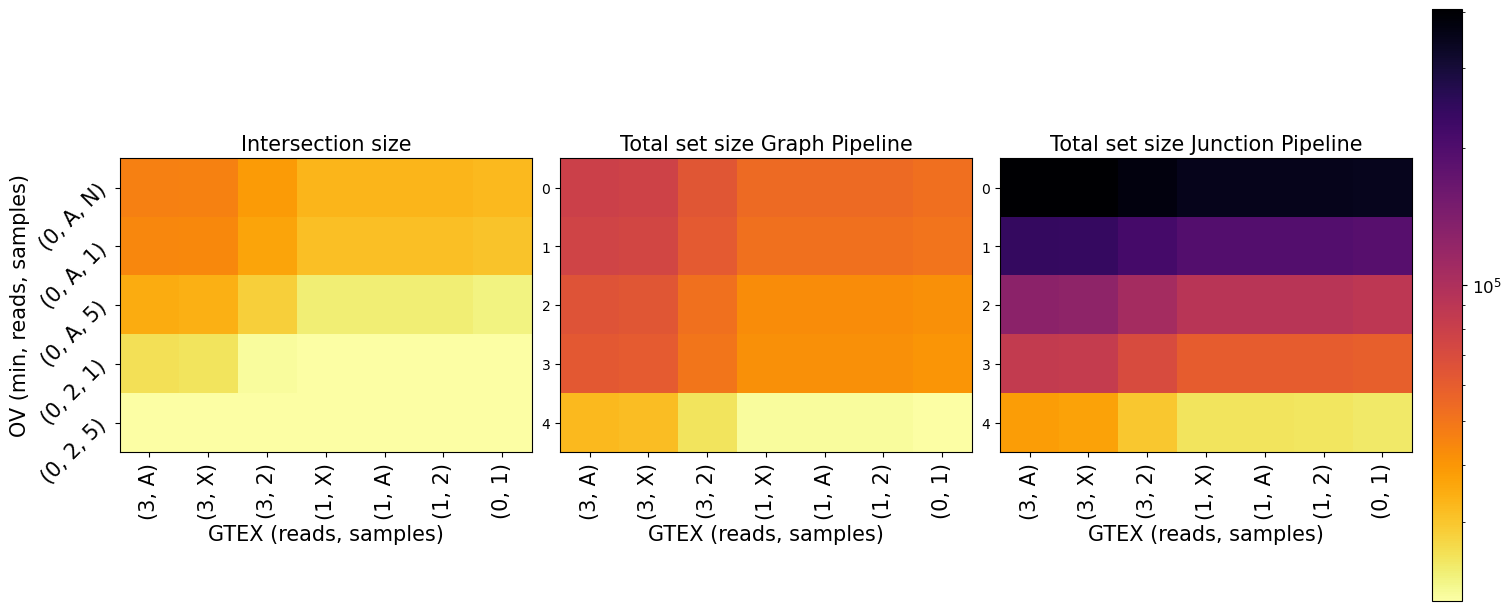

In [41]:
# Plot
nprow = 1
npcol = 3
fig = plt.figure(figsize=(15, 6), layout='constrained')
axes = [fig.add_subplot(nprow, npcol, i) for i in range(1,npcol+1)]

vmin = max(1, np.min([df['size_eth'], df['size_ohsu']]))
vmax = np.max([df['size_eth'], df['size_ohsu']]) #1e5
for pane_idx in np.arange(npcol):
    panelplot=axes[pane_idx].imshow(df_plot[pane_idx], origin='upper', 
                                    cmap='inferno_r', norm=LogNorm(vmin=vmin, vmax=vmax))
    # x-axis 
    axes[pane_idx].set_title(titles[pane_idx], fontsize=label_font_size)
    axes[pane_idx].set_xlabel(xaxis_label, fontsize=label_font_size)
    axes[pane_idx].set_xticks(range(df_plot[pane_idx].shape[1]))
#    axes[pane_idx].set_xticklabels(prepare_backticks(df_plot[pane_idx].columns), rotation = 90 )
    axes[pane_idx].set_xticklabels(df_plot[pane_idx].columns, rotation = 90, fontsize=xticks_font_size)

    if pane_idx == 0 :
        # y-axis
        axes[pane_idx].set_ylabel(yaxis_label, fontsize=label_font_size)
        axes[pane_idx].set_yticks(range(df_plot[pane_idx].shape[0]))
#        axes[pane_idx].set_yticklabels(prepare_frontticks(df_plot[pane_idx].index), rotation = 45 )
        axes[pane_idx].set_yticklabels(df_plot[pane_idx].index, rotation = 45, fontsize=xticks_font_size)
    
cbar = plt.colorbar(panelplot)
cbar.ax.tick_params(labelsize=tick_font_size)

save = True
name = 'Matrix_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
fig.show()


In [71]:
df_plot[2]

filter_background,"(3, A)","(3, X)","(3, 2)","(1, X)","(1, A)","(1, 2)","(0, 1)"
filter_foreground,,,,,,,
"(0, A, N)",405032,401860,375160,349426,349426,349007,344599
"(0, A, 1)",244234,241287,217323,195150,195150,194757,190820
"(0, A, 5)",128791,126439,107268,91641,91641,91308,88503
"(0, 2, 1)",84859,83106,69924,60253,60253,60035,58437
"(0, 2, 5)",38262,37040,29573,24913,24913,24766,23972


In [72]:
df_plot[1]

filter_background,"(3, A)","(3, X)","(3, 2)","(1, X)","(1, A)","(1, 2)","(0, 1)"
filter_foreground,,,,,,,
"(0, A, N)",78373,76534,63803,53930,53930,53822,52430
"(0, A, 1)",76015,74182,61615,51893,51893,51785,50400
"(0, A, 5)",65331,63665,51836,42924,42924,42823,41552
"(0, 2, 1)",62310,60732,49831,41695,41695,41612,40442
"(0, 2, 5)",32447,31386,24940,20683,20683,20638,20052
